In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.patches as patches
% matplotlib inline

In [2]:
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/EXH001*.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))
ptrc=nc.Dataset(nc_filename[0])

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/EXH0010213.nc']


In [3]:
lonNEMO=ptrc.variables['nav_lon'][:,:]
latNEMO=ptrc.variables['nav_lat'][:,:]
dep = ptrc.variables['deptht'][:]


tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy=tmask.variables['mbathy'][0,400:,:]
tmask=tmask.variables['tmask'][0,:,400:,:]


bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

In [4]:
def vel(keyword,T,ENG):
    'design to obtain velocity field'
    if keyword =='U':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s*.nc'%(ENG,T)))
        uvel=nc.Dataset(nc_filename[0])        
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s*.nc'%(ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

In [5]:
def extractData(yearnum,startyear,ENG):
    velcurl=[]
    year=[]
    u30=[]
    v30=[]
    tracer=[]
    ice=[]
    
    for time in range (yearnum):

        u =vel('U',time+startyear,ENG)
        v =vel('V',time+startyear,ENG)
        u30.append(u[30,320,180])
        v30.append(v[30,320,180])
        
        #tracer
        data=np.empty(4)
        for string,index in zip(['TR_7','TR_8','TR_9','TR_10'],[0,1,2,3]):
            data[index]=ptrc.variables[string][time,30,320,180]
            
        tracer.append(data)
        
        #ice
        data=np.empty(2)
        for string,index in zip(['TR_11','TR_12'],[0,1]):
            data[index]=ptrc.variables[string][time,30,320,180]
        ice.append(data)
        
        
        year.append(time+startyear)
        
    return np.array(tracer),np.array(ice),u30,v30,year

In [7]:
tracer,ice,u30,v30,year=extractData(yearnum=12,startyear=2002,ENG='EXH001')

In [8]:
colors = plt.cm.rainbow(np.linspace(0, 1, 6))
def twinplot(data1,ax1label,data2,ax2label,color1=colors[5],color2=colors[1]):
    '''design to plot two variables in one plot'''
    fig, ax1 = plt.subplots()

    ax1.plot(year,data1,color=color1,lw=1.5)
    ax1.set_ylabel(ax1label, color=color1)
    for tl in ax1.get_yticklabels():
        tl.set_color(color1)

    ax2 = ax1.twinx()
    ax2.plot(year,data2,color=color2,lw=1.5)
    ax2.set_ylabel(ax2label, color=color2)
    for tl in ax2.get_yticklabels():
        tl.set_color(color2)
    return ax1,ax2

# What controls the changes in our model?

The velocity seems to be either north-west or south-east


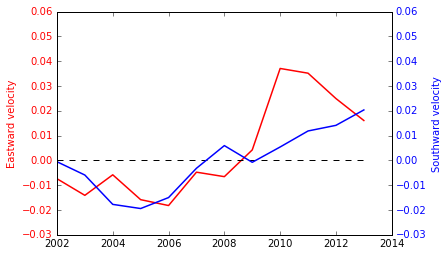

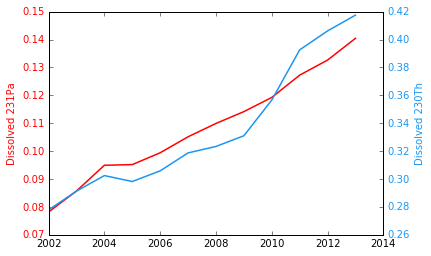

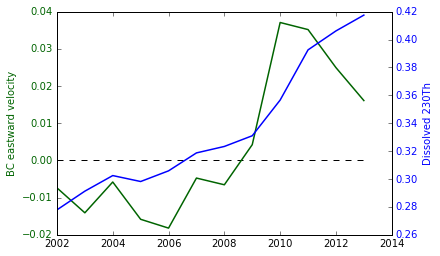

In [10]:
#velocity
print ('The velocity seems to be either north-west or south-east')
ax1,ax2=twinplot(data1=u30,ax1label='Eastward velocity',data2=v30,ax2label='Southward velocity',color1='r',color2='b')
ax1.set_ylim(-0.03,0.06)
ax2.set_ylim(-0.03,0.06)
plt.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.show()

#tracers
twinplot(data1=tracer[:,0],ax1label='Dissolved 231Pa',data2=tracer[:,1],ax2label='Dissolved 230Th')
ax1,ax2=twinplot(data1=u30,ax1label='BC eastward velocity',data2=tracer[:,1],ax2label='Dissolved 230Th',\
                 color1='darkgreen',color2='b')
#plt.axvspan(1999, 2005, alpha=0.3, color='grey')
#plt.axvspan(1988, 1993, alpha=0.3, color='grey')
#plt.axvspan(1978, 1983, alpha=0.3, color='grey')
ax1.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.show()

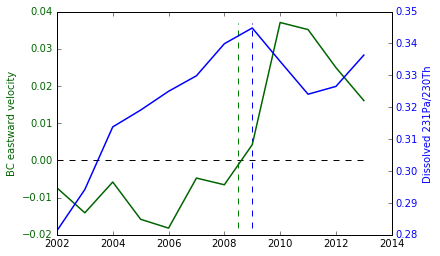

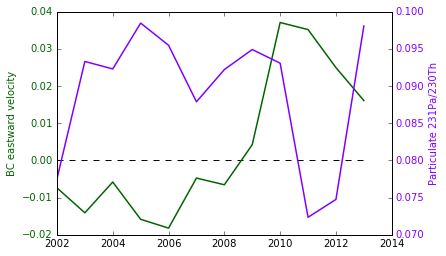

In [24]:
ax1,ax2=twinplot(data1=u30,ax1label='BC eastward velocity',data2=tracer[:,0]/tracer[:,1],
                 ax2label='Dissolved 231Pa/230Th',
                 color1='darkgreen',color2='b')
ax1.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
ax1.vlines(x=2009,ymin=np.min(u30),ymax=np.max(u30),linestyles='--',color='b')
ax1.vlines(x=2008.5,ymin=np.min(u30),ymax=np.max(u30),linestyles='--',color='g')

ax1,ax2=twinplot(data1=u30,ax1label='BC eastward velocity',data2=tracer[:,2]/tracer[:,3],
                 ax2label='Particulate 231Pa/230Th',
                 color1='darkgreen',color2=colors[0])

ax1.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')

The particulate tracer fields begin to follow the corresponding particle field since 1980.231Pa follows the particle field nicely while 231Th stops coming after the particle field from 2000s.Both of the particle field look very similar.


(<matplotlib.axes._subplots.AxesSubplot at 0x7f9cc3e99cf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9cc3e23d30>)

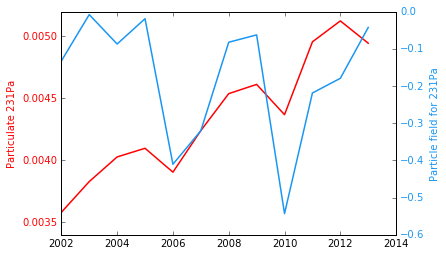

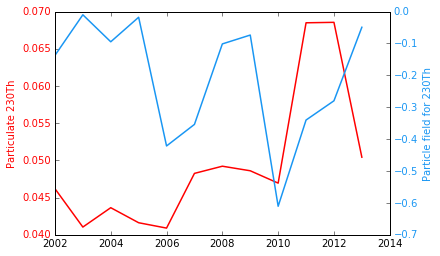

In [11]:
#tracer and ice
print ('The particulate tracer fields begin to follow the corresponding particle field since 1980.\
231Pa follows the particle field nicely while 231Th stops coming after the particle field from 2000s.\
Both of the particle field look very similar.')
twinplot(data1=tracer[:,2],ax1label='Particulate 231Pa',data2=-ice[:,0],ax2label='Particle field for 231Pa')
twinplot(data1=tracer[:,3],ax1label='Particulate 230Th',data2=-ice[:,1],ax2label='Particle field for 230Th')

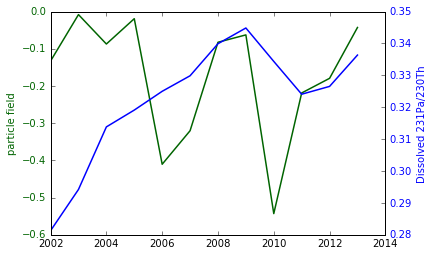

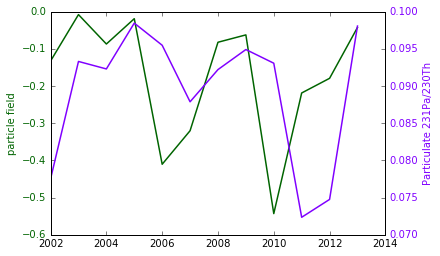

In [15]:
ax1,ax2=twinplot(data1=-ice[:,0],ax1label='particle field',data2=tracer[:,0]/tracer[:,1],
                 ax2label='Dissolved 231Pa/230Th',
                 color1='darkgreen',color2='b')


ax1,ax2=twinplot(data1=-ice[:,0],ax1label='particle field',data2=tracer[:,2]/tracer[:,3],
                 ax2label='Particulate 231Pa/230Th',
                 color1='darkgreen',color2=colors[0])

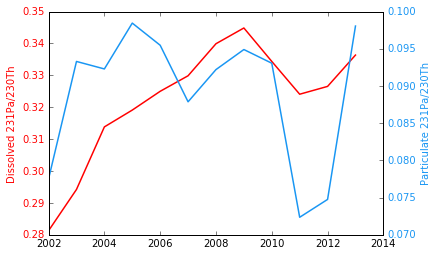

In [25]:
ax1,ax2=twinplot(data1=tracer[:,0]/tracer[:,1],
                 ax1label='Dissolved 231Pa/230Th',
                 data2=tracer[:,2]/tracer[:,3],
                 ax2label='Particulate 231Pa/230Th')